In [1]:
import os
import shutil
import glob

# h5py can read hdf5 dataset
import h5py

# delete bad data files
from send2trash import send2trash

# fastmri has some k-space undersampling functions we can use
# git clone https://github.com/facebookresearch/fastMRI.git
# go to the fastmri directory
# pip install -e .
import fastmri

# We will use this functions to generate masks
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

# sigpy is apparently a good MRI viewing tool
# pip install sigpy
import sigpy as sp
import sigpy.plot as pl

import numpy as np

import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

In [2]:
# define paths

# # master
DATASETS = [
    'singlecoil_train',
    'singlecoil_val',
    'singlecoil_test_v2'
]


AXES = {
        'singlecoil_train' : (1, 2),
        'multicoil_train' : (2, 3),
       }

# single dataset, for debugging / demo purposes. cwd is home directory
DATASET = 'singlecoil_train' #singlecoil_val, singlecoil_test_v2
data_path = os.path.join(os.getcwd(), DATASET)
mri_paths = glob.glob(os.path.join(data_path, '*01.h5'))
data_save_path = os.path.join('/central/groups/BEBi_205_Spring_2021/vliu/dataset_objects', DATASET) 

In [3]:
# this block gets Dataset object with imaginary and real separated
def _get_kspace_and_reconstruction_rss(filename):
    """
    @params filename: full path to .h5 mri file
    @return kspace data of that particular file
    """
    try:
        with h5py.File(filename, 'r') as hr:
            return hr['kspace'][:], hr['reconstruction_rss'][:]
    except:
        print(f'Error could not open {filename}')

def _get_kspace_undersampled(kspace, center_fractions = [0.04], accelerations = [4]):
    """
    @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params center_fractions: for undersampling, 
        N*center_fraction columns in center corresponding to low-frequencies
    @params accelerations: how much mri acquisition is sped up
    @return undersampled k-space
    """
    mask_func = RandomMaskFunc(
        center_fractions = center_fractions, 
        accelerations = accelerations
    )
    mask = np.array(mask_func(kspace.shape))
    return kspace * mask



def _get_mri_im_separated(
#     kspace, 
    reconstruction_rss,
    kspace_undersampled, 
    DATASET
):
    """
    separates imaginary from real values
    # @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params reconstruction_rss: reconstructed MR image of fully sampled kspace, provided
    @params kspace_undersampled: mask-undersampled k-space from _get_kspace_undersampled
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_im = sp.ifft(kspace_undersampled, axes=AXES[DATASET])
#     fullysampled_im = sp.ifft(kspace, axes=AXES[DATASET])
    
    #crop to make sure images are all the size
    undersampled_crop = sp.resize(
        undersampled_im,
        [1, 32, 256, 256]
#         [1, 30, 320, 320] # [batch size, height, length, width]
    )
    
    undersampled_crop_real = tf.math.real(undersampled_crop)
    undersampled_crop_imag = tf.math.imag(undersampled_crop)
    
    undersampled_crop = np.stack(
        (undersampled_crop_real, undersampled_crop_imag),
        axis = 4,
    )
    
    
    fullysampled_crop = sp.resize(
        reconstruction_rss,
        [1, 32, 256, 256]
#         [1, 30, 320, 320]
    )
    
    
    return (
        undersampled_crop,
        fullysampled_crop,
    )
    



def get_datum_from_single_file_separated(filename, DATASET):
    """
    user-facing function for tf Dataset object
    @params filename: full path to .h5 mri file
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    kspace, reconstruction_rss = _get_kspace_and_reconstruction_rss(filename)
    kspace_undersampled = _get_kspace_undersampled(kspace)
    return _get_mri_im_separated(
        reconstruction_rss,
        kspace_undersampled,
        DATASET,
    )




def get_data_from_files_separated(filenames, DATASET):  
    """
    user-facing function for tf Dataset object
    @params filenames: list of full paths to .h5 mri files
    @params DATASET: i.e. 'singlecoil_train' or 'multicoil_train'
    @return ndarray of 
        (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    print_marker = 1
    
    undersampled_images = np.ones((len(filenames), 32, 256, 256, 2)) #[bn, h, l, w, c]
    fullysampled_images = np.ones((len(filenames), 32, 256, 256))

    for i, mri_path in enumerate(filenames):
        try:
            # undersampled_crop has real and imag components
            undersampled_crop, fullysampled_crop = get_datum_from_single_file_separated(
                mri_path, DATASET
            )
               

            undersampled_images[i] = undersampled_crop
            
            fullysampled_images[i] = fullysampled_crop
            
            print_marker += 1
            if print_marker % 50 == 0:
                print(f'undersampled {print_marker} {DATASET} files thus far')
            
#             print (f'undersampled image shape: {undersampled_crop.shape}')           
#             print (f'undersampled images running total shape: {undersampled_images.shape}')
#             print (f'fully sampled images running total shape {fullysampled_images.shape} \n\n')

            
            
        except:
            print(f'could not open file {mri_path}')
#             send2trash(mri_path)
            print(f'sent file {mri_path} to trash')
    
    # reshape with extra one at the end for channel
    fullysampled_images = fullysampled_images.reshape(
        (-1, 32, 256, 256, 1)
    )


    return undersampled_images[1:], fullysampled_images[1:]

#


def save_data(mri_paths, DATASET, data_save_path):
    '''
    save MRIs as tf.data.Dataset object,
    undersampled and fully sampled MR images together
    @params mri_paths: glob directory of ALL MRI paths
    @params dataset: name of DATASET (singlecoil_train)
    @params data_save_path: where the tf.data.Dataset is saved
    
    '''
    under_sampled_separated, fully_sampled_separated = get_data_from_files_separated(mri_paths, DATASET)

    
#     ds_separated = tf.data.Dataset.from_tensor_slices((under_sampled_separated, fully_sampled_separated))
#     ds_separated = ds_separated.shuffle(1000, seed = 123, reshuffle_each_iteration = True)
    
    # save Dataset object
    if os.path.isdir(data_save_path):
        YN = input(f'delete {data_save_path}? Y or N?')
        if YN == 'Y':
            shutil.rmtree(data_save_path)

#     tf.data.experimental.save(ds_separated, data_save_path)
    np.savez(data_save_path, under_sampled_separated, fully_sampled_separated)
             
    print (f'> > successfully saved Dataset object for {DATASET} \n\n')
    
    return True


def master():
    '''
    main program to execute save_data for all datasets
    including train, val, and test
    '''
    for DATASET in DATASETS:
        print (f'> > > processing {DATASET} images')
        # define paths
        data_path = os.path.join(
            '/central/groups/BEBi_205_Spring_2021/vliu', 
            DATASET
        )
        mri_paths = glob.glob(os.path.join(data_path, '*.h5'))
        data_save_path = os.path.join(
            '/central/groups/BEBi_205_Spring_2021/vliu/dataset_objects', 
            DATASET
        )
        save_data(mri_paths, DATASET, data_save_path) 

In [4]:
# K.clear_session()
# master()

In [5]:
# single dataset for debugging / demo purposes
save_data(mri_paths, DATASET, data_save_path)



# new_dataset = tf.data.experimental.load(data_save_path,
#     (tf.TensorSpec(shape=(32, 256, 256, 2), dtype=tf.float64, name=None),
#      tf.TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float64, name=None)) # ds_separated.element_spec
#     )

# new_dataset = new_dataset.shuffle(1000, seed = 123, reshuffle_each_iteration = True)

# check Dataset object was created properly
for undersampled_im, fullysampled_im in .take(10):
    undersampled_im = tf.reshape(undersampled_im, (-1, 32, 256, 256, 2))
    fullysampled_im = tf.reshape(fullysampled_im, (-1, 32, 256, 256, 1))
    print(f'undersampled size {undersampled_im.shape} fullysampled size {fullysampled_im.shape}')

# new_dataset = new_dataset.shuffle(1000)
# for undersampled_im, fullysampled_im in new_dataset.take(1):
# #     undersampled_im = tf.reshape(undersampled_im, (-1, 32, 256, 256, 2))
#     pl.ImagePlot(undersampled_im[:, :, :, 0]) #this is just real numbers. Don't use this in comparison
#     pl.ImagePlot(fullysampled_im[:, :, :, 0])

> > successfully saved Dataset object for singlecoil_train 




NameError: name 'new_dataset' is not defined

undersampled size (1, 32, 256, 256, 2) fullysampled size (1, 32, 256, 256, 1)
undersampled size (1, 32, 256, 256, 2) fullysampled size (1, 32, 256, 256, 1)
undersampled size (1, 32, 256, 256, 2) fullysampled size (1, 32, 256, 256, 1)


<IPython.core.display.Javascript object>


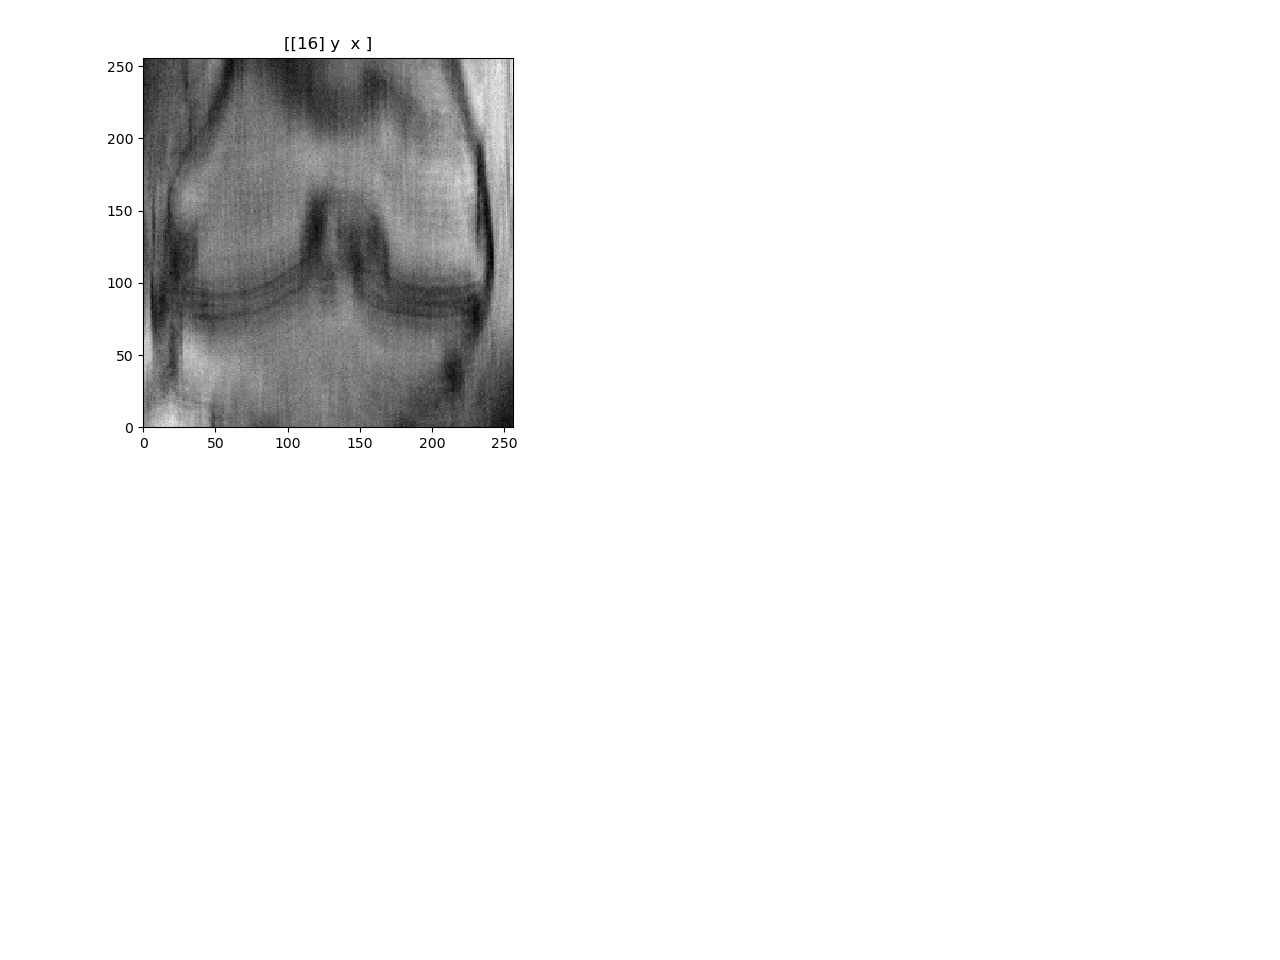

<IPython.core.display.Javascript object>


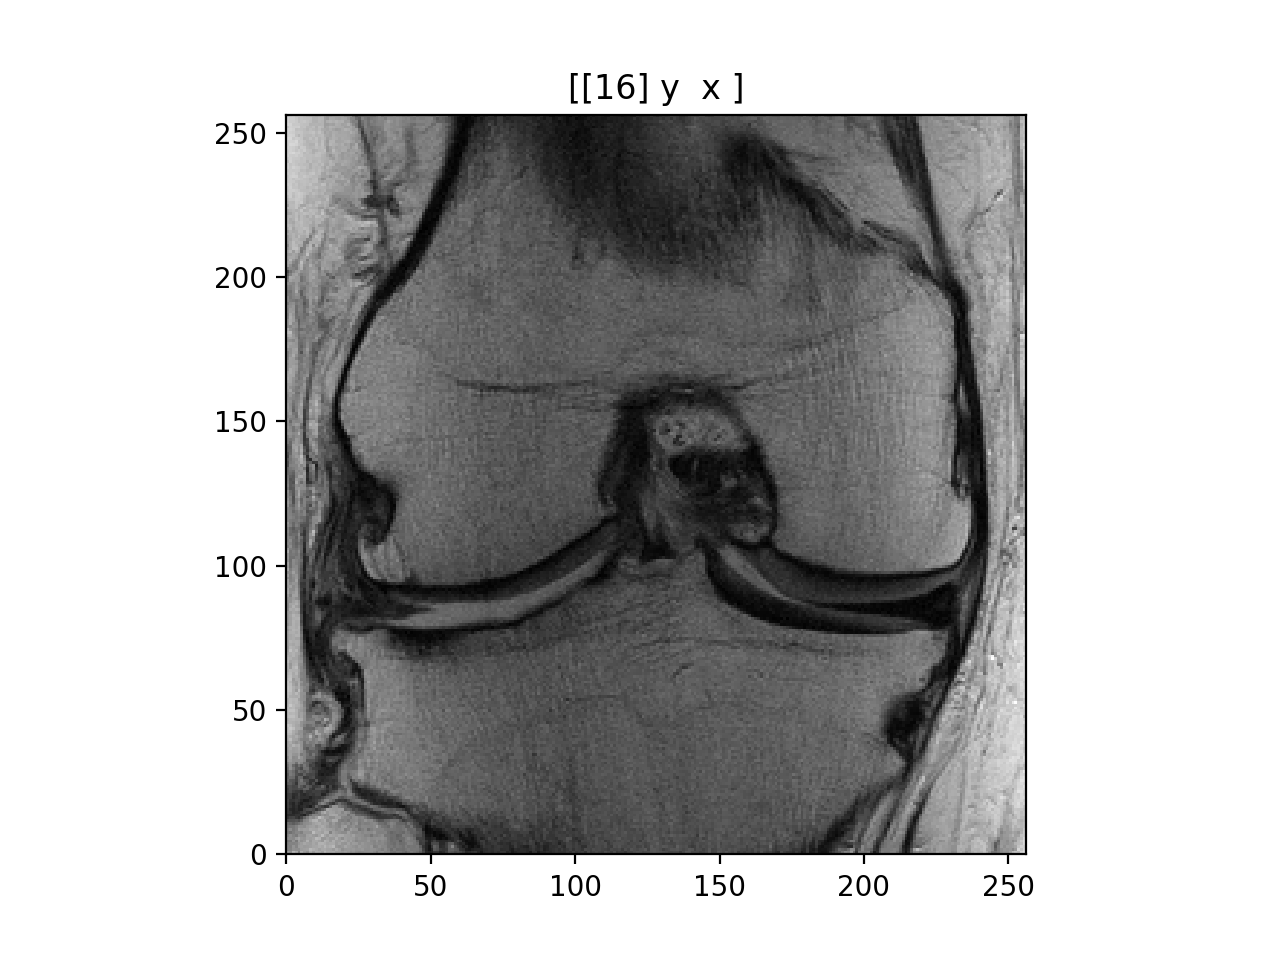

In [9]:
npzfile = np.load(f'{data_save_path}.npz')
under_sampled_separated = npzfile['arr_0']
fully_sampled_separated = npzfile['arr_1']

ds_separated = tf.data.Dataset.from_tensor_slices((under_sampled_separated, fully_sampled_separated))
ds_separated = ds_separated.shuffle(1000, seed = 123, reshuffle_each_iteration = True)

# check Dataset object was created properly
for undersampled_im, fullysampled_im in ds_separated.take(10):
    undersampled_im = tf.reshape(undersampled_im, (-1, 32, 256, 256, 2))
    fullysampled_im = tf.reshape(fullysampled_im, (-1, 32, 256, 256, 1))
    print(f'undersampled size {undersampled_im.shape} fullysampled size {fullysampled_im.shape}')
    
ds_separated = ds_separated.shuffle(1000)
for undersampled_im, fullysampled_im in ds_separated.take(1):
#     undersampled_im = tf.reshape(undersampled_im, (-1, 32, 256, 256, 2))
    pl.ImagePlot(undersampled_im[:, :, :, 0]) #this is just real numbers. Don't use this in comparison
    pl.ImagePlot(fullysampled_im[:, :, :, 0])